# Image Analysis for datasets

This example notebook shows how to use datasetinsights to do image analysis on datasets. Please change the code as per your visulization requirements.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
from pycocotools.coco import COCO
from datasetinsights.stats.image_analysis import (
    get_bbox_var_laplacian,
    get_bbox_fg_bg_var_laplacian,
    laplacian_img,
    get_final_mask,
    get_seg_fg_bg_var_laplacian
)
from datasetinsights.stats.image_analysis import get_average_psd_1d
from datasetinsights.stats.image_analysis import get_wt_coeffs_var

#### Update the config

In [23]:
# Add datasets to the folowing dict. Add annotation file path, image directory path and image type (png, jpg).
# After updating you can run Cell -> Run All
config = {
    "Dataset_A": {"annotation_file_path": "<file-path>", "img_dir_path": "<img-dir-path>", "img_type": "png"},
    "Dataset_B": {"annotation_file_path": "<file-path>", "img_dir_path": "<img-dir-path>", "img_type": "png"},
}
# set this if you want to save the plots to a directory else None
plot_dest_dir = None

In [ ]:
coco_obj_dict = {}
for data in config:
    ann_file_path = config[data]["annotation_file_path"]
    coco_obj = COCO(ann_file_path)
    coco_obj_dict[data] = coco_obj

## Variance of Laplacian

In [ ]:
vars_dict = {}
for data in config:
    vars_dict[data] = {"Entire_Image":[], "Foreground": [], "Background": []}

for data in coco_obj_dict:
    coco_obj = coco_obj_dict[data]
    img_dir = config[data]["img_dir_path"]
    img_ids = coco_obj.getImgIds()
    img_nan, fg_nan, bg_nan = 0, 0, 0
    for img_id in tqdm(img_ids):
        img_meta_data = coco_obj.loadImgs(ids=[img_id])
        file_name = img_meta_data[0]['file_name']

        img_path = os.path.join(img_dir, file_name)
        laplacian = laplacian_img(img_path)
        if np.isnan(laplacian.var()) or laplacian.var() == 0.0:
            img_nan += 1
        else:
            vars_dict[data]["Entire_Image"].append(laplacian.var()) 

        ann_ids = coco_obj.getAnnIds(imgIds=img_id)
        annotations = coco_obj.loadAnns(ann_ids)
        fg_vars, bg_var = get_bbox_fg_bg_var_laplacian(laplacian, annotations)
        for var in fg_vars:
            if np.isnan(var) or var == 0.0:
                fg_nan += 1
            else:
                vars_dict[data]["Foreground"].append(var) 
            
        if np.isnan(bg_var) or bg_var == 0.0:
            fg_nan += 1
        else:
            vars_dict[data]["Background"].append(bg_var) 
    print(f"Dataset: {data}")
    print(f"Discarded {img_nan} image vars due to NaN values. Total image laplacian vars: {len(vars_dict[data]['Entire_Image'])}")
    print(f"Discarded {fg_nan} foreground vars due to NaN values. Total forground laplacian vars: {len(vars_dict[data]['Foreground'])}")
    print(f"Discarded {bg_nan} backgroundedground vars due to NaN values. Total background laplacian vars: {len(vars_dict[data]['Background'])}")




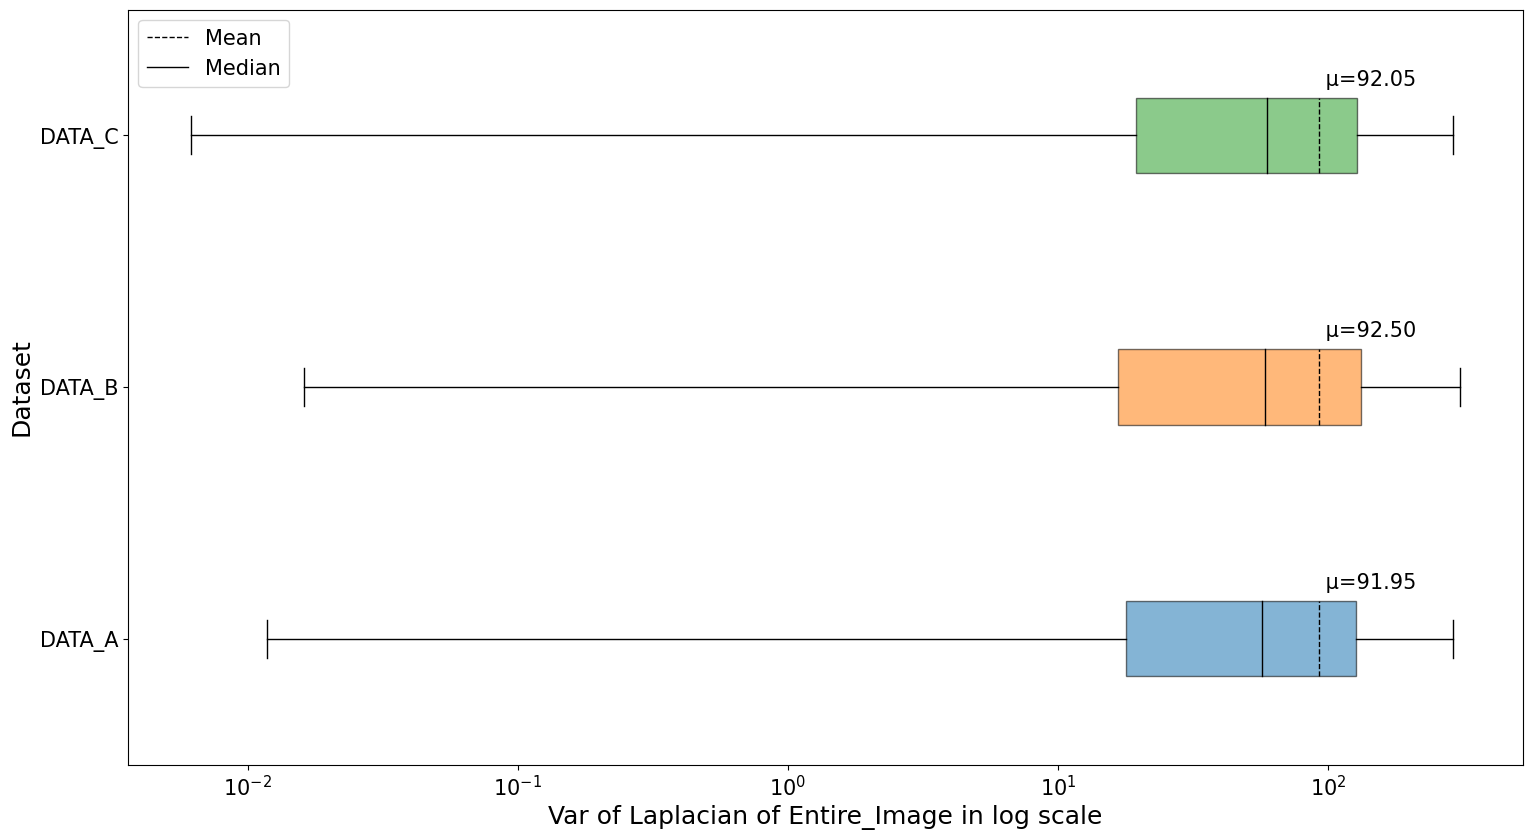

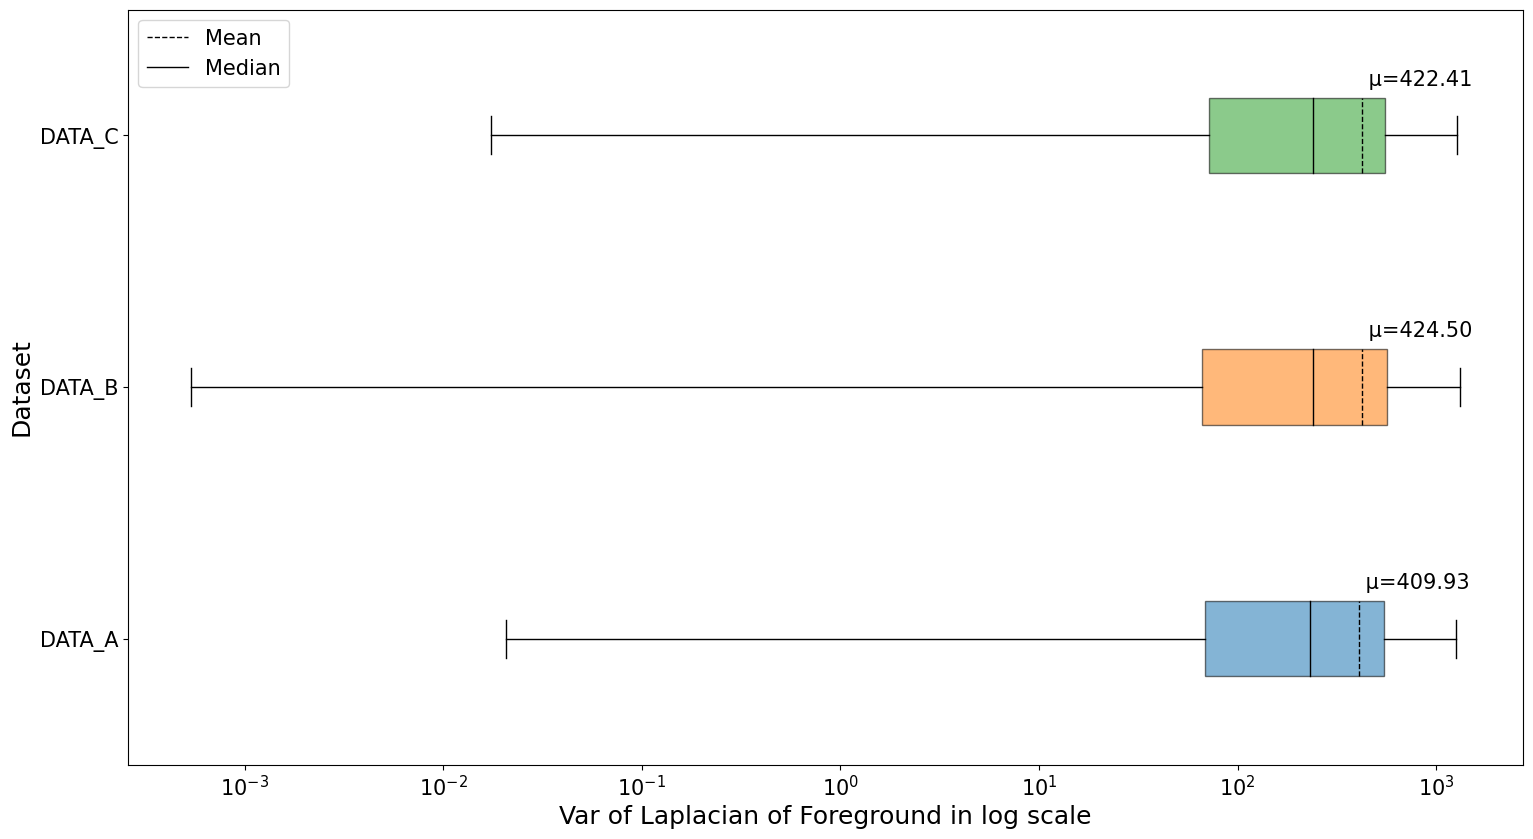

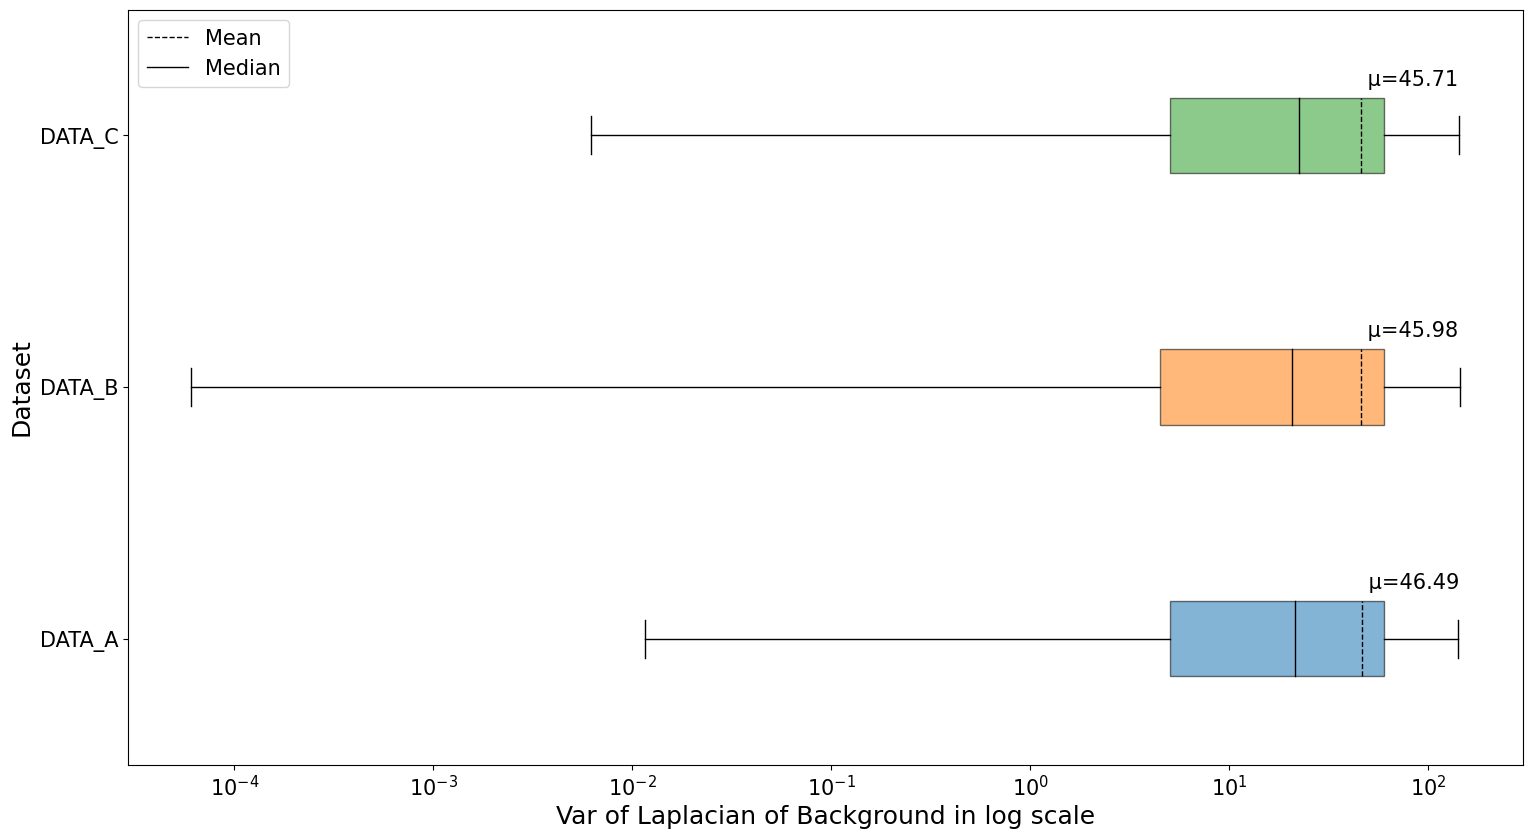

In [24]:
for plot_type in ["Entire_Image", "Foreground", "Background"]:
    box_plot_data = []
    for data in vars_dict:
        box_plot_data.append(vars_dict[data][plot_type])
        
    fig, ax = plt.subplots(dpi=100, figsize=(18,10))

    box = ax.boxplot(box_plot_data,vert=0,patch_artist=True,labels=vars_dict.keys(), 
                     showmeans=True, meanline=True, showfliers=False,)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.55)

    for median in box['medians']:
        median.set_color('black')
    for i, means in enumerate(box['means']):
        means.set_color('black')
        x, y = means.get_xydata()[1]
        mean = np.array(box_plot_data[i]).mean()
        text = ' μ={:.2f}'.format(mean)
        ax.annotate(text, xy=(x, y+0.05), fontsize=15)


    plt.plot([], [], '--', linewidth=1, color='black', label='Mean')
    plt.plot([], [], '-', linewidth=1, color='black', label='Median')

    plt.legend(fontsize=15, loc="upper left")


    plt.xticks(fontsize=15 )
    plt.yticks(fontsize=15 )
    plt.xscale('log')
    plt.minorticks_off()
    plt.xlabel(f"Var of Laplacian of {plot_type} in log scale", fontsize=18)
    plt.ylabel("Dataset", fontsize=18)
    if plot_dest_dir:
        plt.savefig(os.path.join(plot_dest_dir, f"var_lap_{plot_type}.png"))
        plt.savefig(os.path.join(plot_dest_dir, f"var_lap_{plot_type}.pdf"))
    plt.show()

## Spectral Analysis

In [ ]:
psd_1d_dict = {}
for data in config:
    img_dir_path = config[data]["img_dir_path"]
    img_type = config[data]["img_type"]
    avg_psd_1d, _ = get_average_psd_1d(img_dir=img_dir_path, img_type=img_type)
    psd_1d_dict[data] = avg_psd_1d

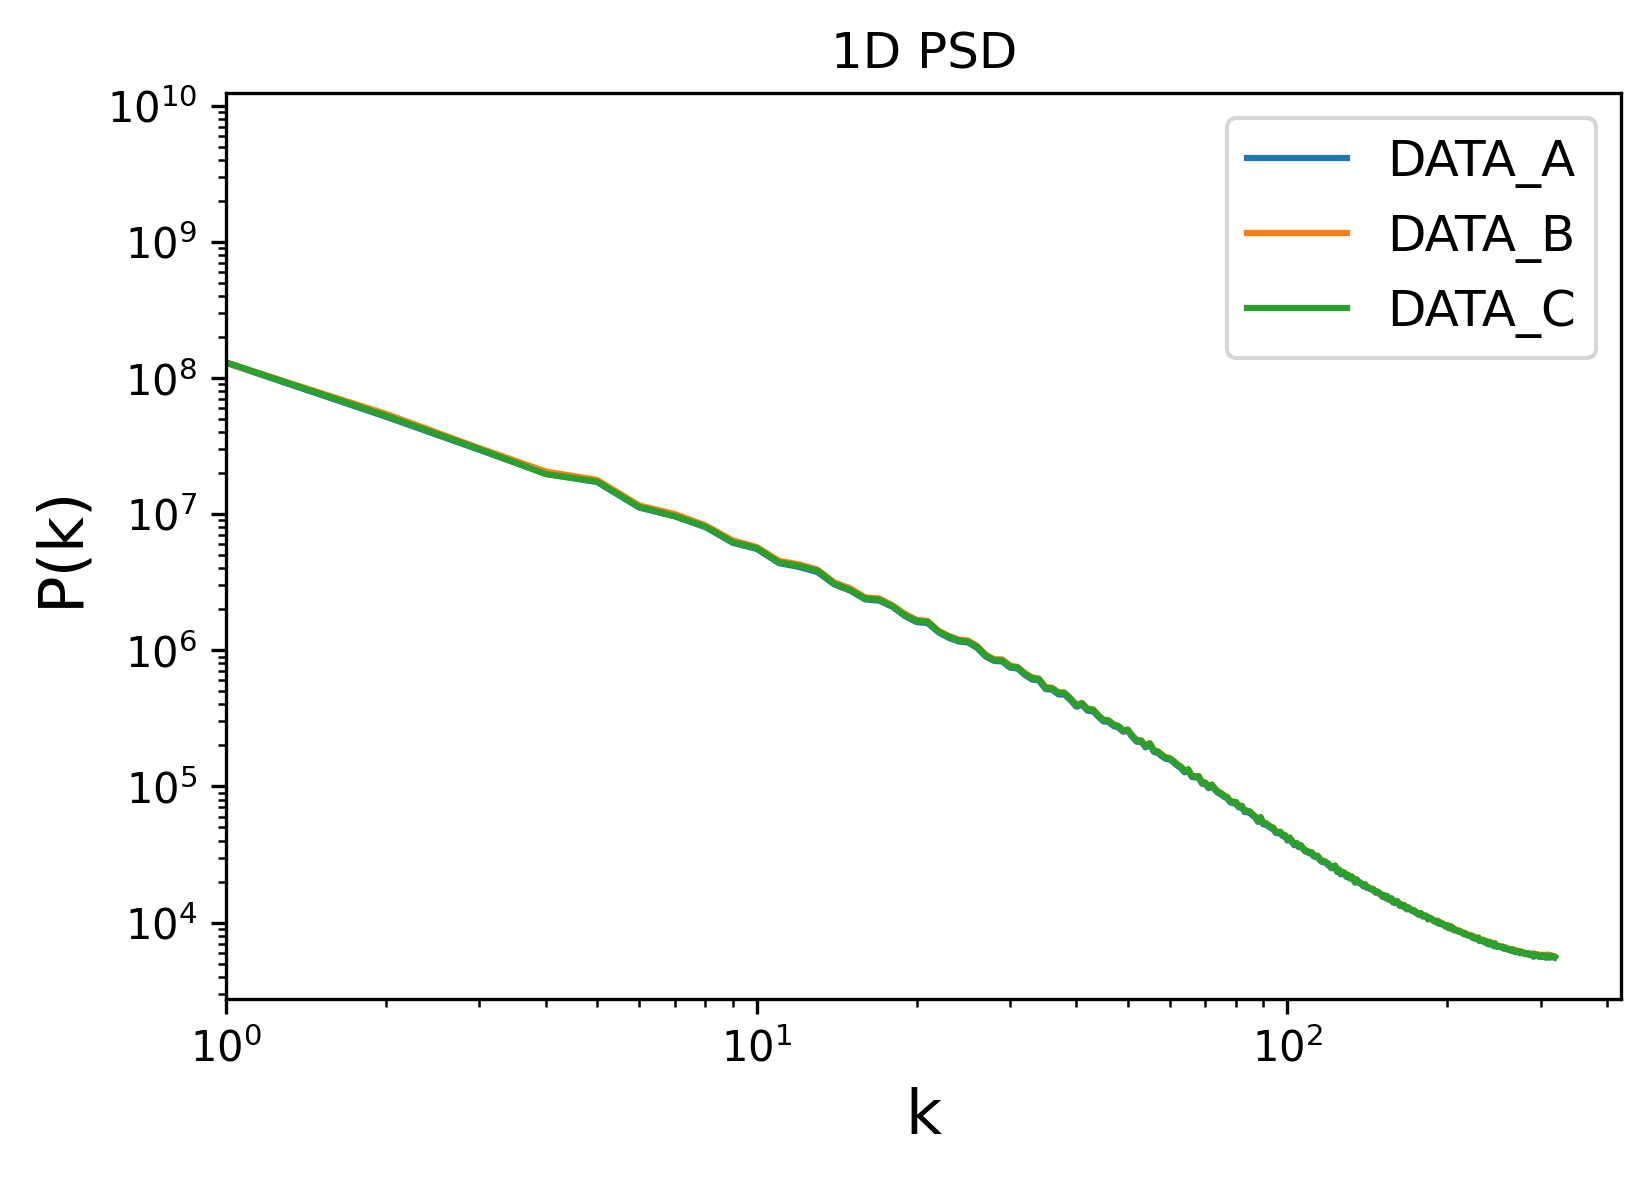

In [25]:
fig, ax = plt.subplots(dpi=300)
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for data in psd_1d_dict:
    ax.plot(psd_1d_dict[data], color=next(colors), label=data)

plt.legend(fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel("P(k)", fontsize=15)
plt.xlabel("k", fontsize=15)
plt.title("1D PSD")
plt.xlim([1, None])
if plot_dest_dir:
    plt.savefig(os.path.join(plot_dest_dir, f"psd.png"))
    plt.savefig(os.path.join(plot_dest_dir, f"psd.pdf"))

## Wavelet Transform

In [ ]:
coeff_dict = {}
for data in config:
    coeff_dict[data] = {}
    
for data in config:
    img_dir_path = config[data]["img_dir_path"]
    img_type = config[data]["img_type"]
    horizontal_coeff, vertical_coeff, diagonal_coeff = get_wt_coeffs_var(img_dir_path, img_type)
    coeff_dict[data]["Horizontal"] = horizontal_coeff
    coeff_dict[data]["Vertical"] = vertical_coeff
    coeff_dict[data]["Diagonal"] = diagonal_coeff

In [10]:
hist_dict = {}
for data in coeff_dict:
    hist_dict[data] = {}
for data in coeff_dict:
    for key in coeff_dict[data]:
        coeff = coeff_dict[data][key]
        hist = plt.hist(coeff, bins=np.logspace(np.log10(max([min(coeff), np.finfo(float).eps])), np.log10(max(coeff))))
        plt.close()
        hist_dict[data][key] = hist


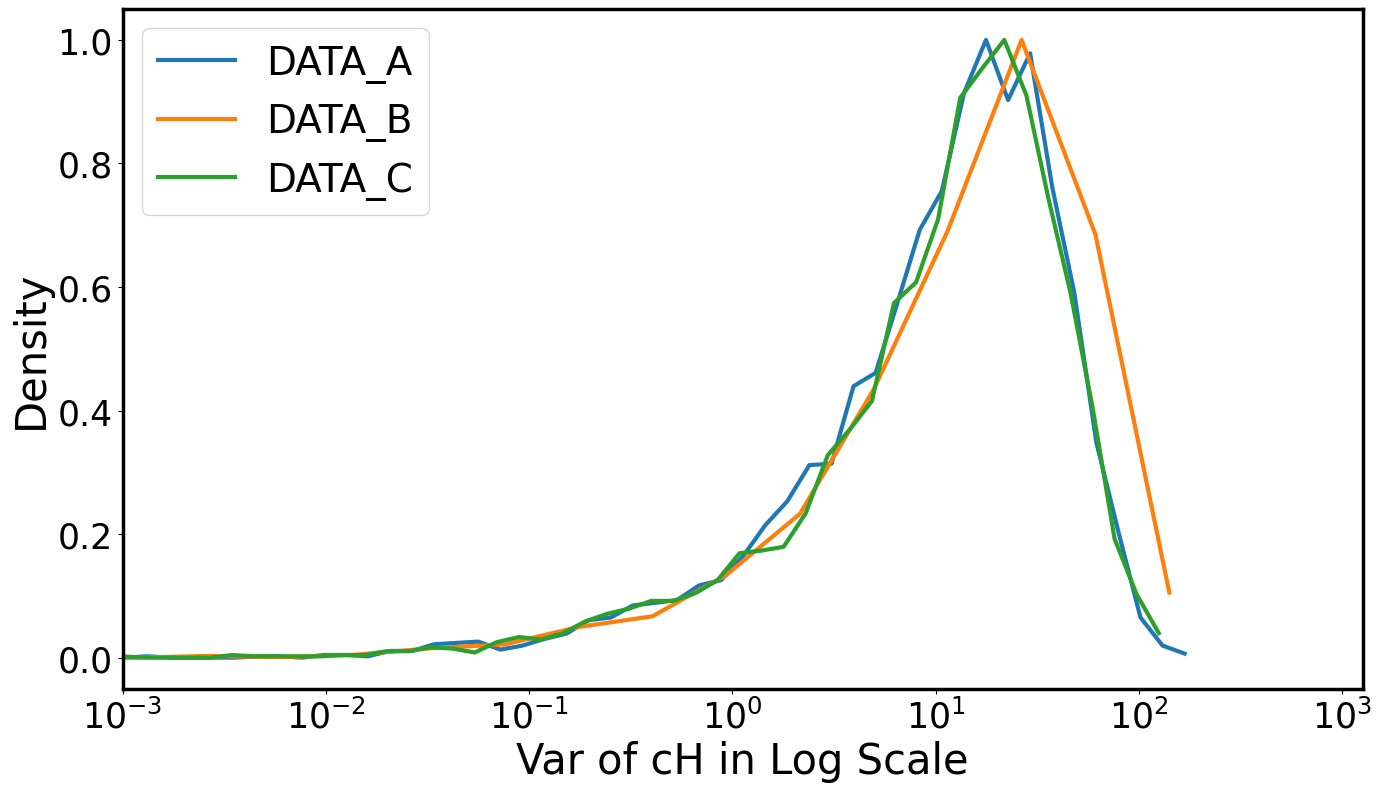

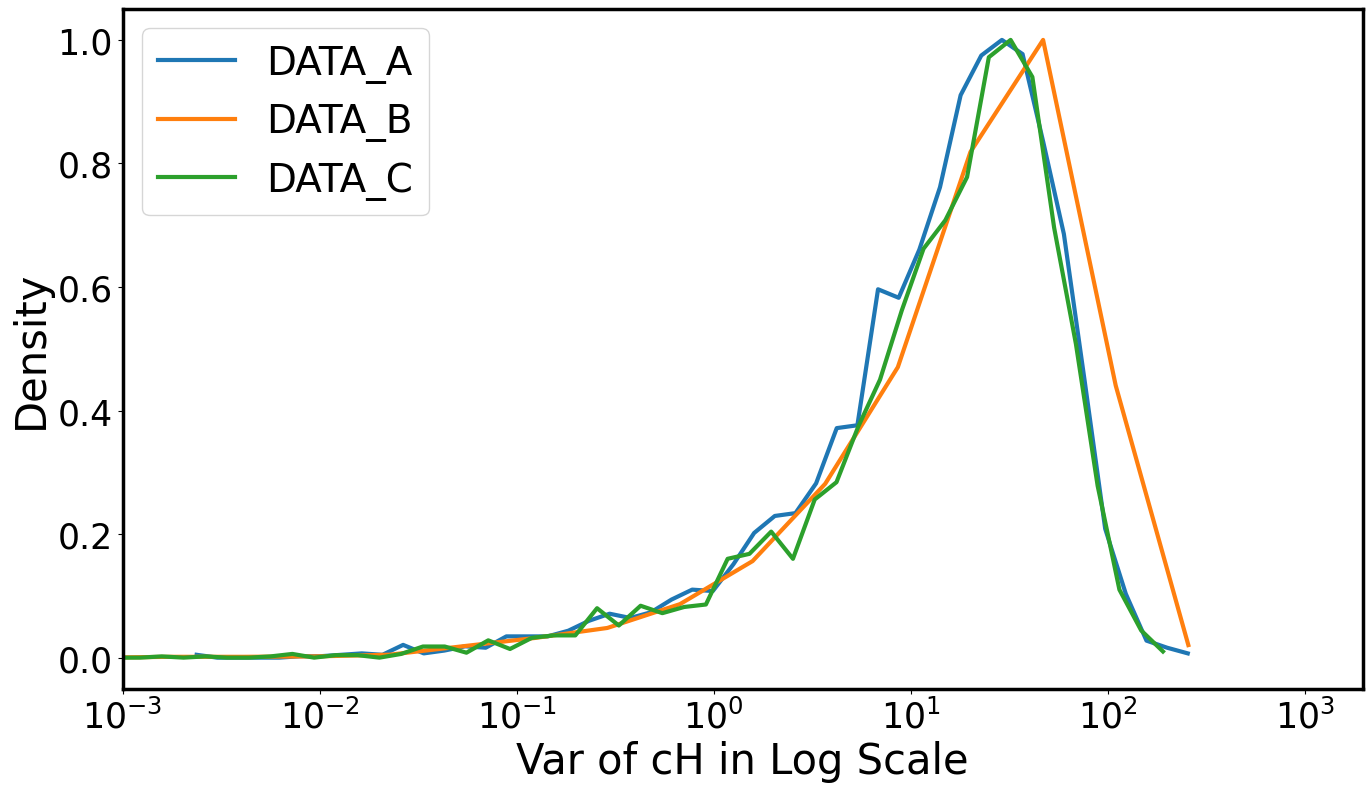

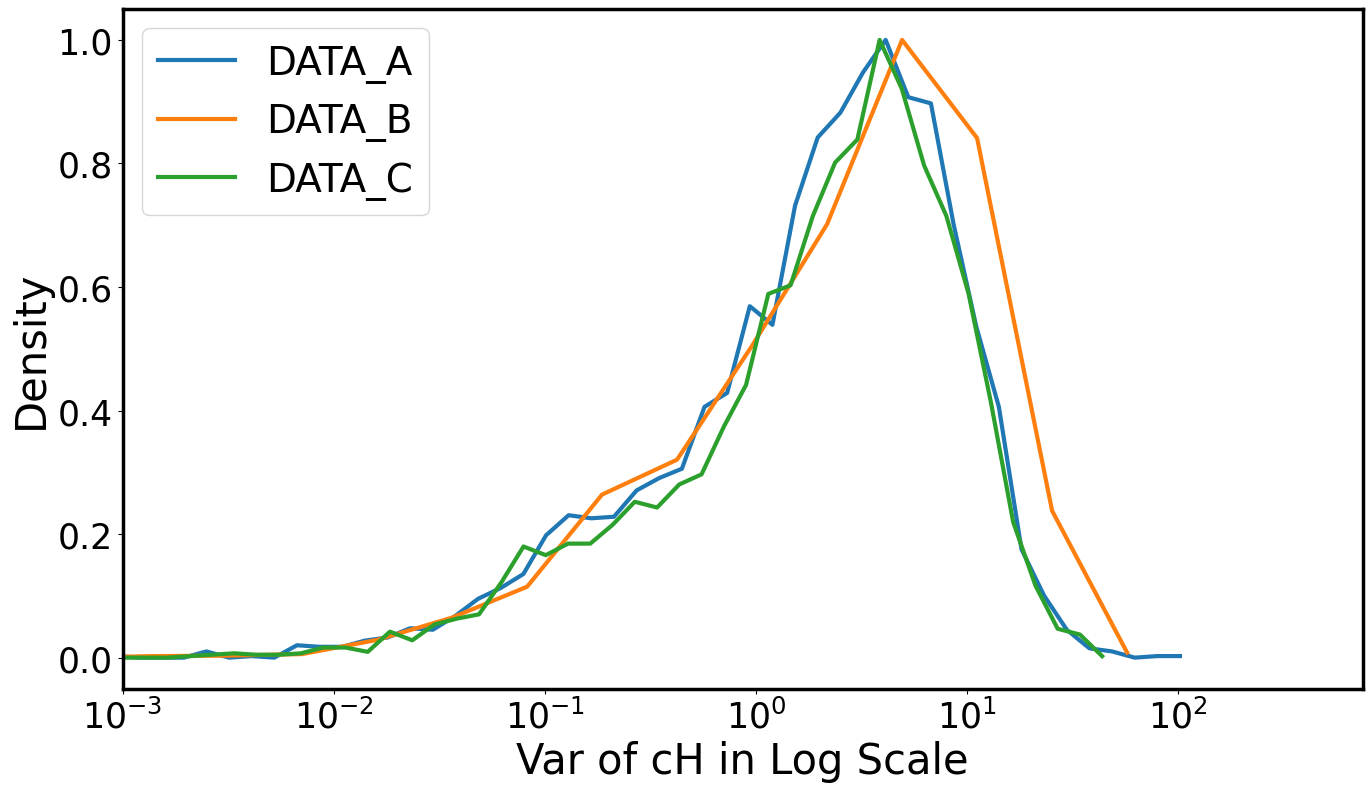

In [26]:
for plot_type in ["Horizontal", "Vertical", "Diagonal"]:
    fig, ax = plt.subplots(dpi=100, figsize=(16,9))
    colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for data in hist_dict:
        hist = hist_dict[data][plot_type]
        norm_data = (hist[0] - min(hist[0]))/(max(hist[0])-min(hist[0]))
        ax.plot(hist[1][1:],norm_data, linestyle='-',  label=data, linewidth=3, color=next(colors))

    ax.set_xscale('log')
    ax.minorticks_off()

    plt.legend(loc="upper left", fontsize=28)
    plt.xlabel("Var of cH in Log Scale", fontsize=30)
    plt.ylabel("Density", fontsize=30)
    plt.xticks(fontsize=25 )
    plt.yticks(fontsize=25 )
    # Update limit accordingly
    plt.xlim(1/1000, None)

    plt.setp(ax.spines.values(), linewidth=2.5)
    if plot_dest_dir:
        plt.savefig(os.path.join(plot_dest_dir, f"var_wav_{plot_type}.png"))
        plt.savefig(os.path.join(plot_dest_dir, f"var_wav_{plot_type}.pdf"))

    plt.show()